# Recipes as a Service

The goal of this project is to create recipe recommendations that optimize the use of ingredients. By finding recipes that have a high number of ingredients in common we as consumers are able to decrease our food expenses while utilizing our groceries more effectively. Furthermore, by using the store's promotions we are able to reduce expenses even further and help the stores sell the items they wish to get rid of.

## Background

I have always had a hard time at planning a week's meals. It is trivial to randomly pick 7 recipes from a list of recipes and create a shopping list by concatenating the recipes' ingredients list. Although this approach results in a varied week, such a grocery list is extremely expensive! A second problem that I have have is the ineffective usage of all food items in the fridge. Having to throw out vegetables because of spoilage is a problem that could easily be avoided if all food items had a purpose.

## This post

In this post we explore various ways of finding recipes that have ingredients in common. Although this task might seem simple at first, it turns out that the problem has a factorial time complexity. Given 1000 recipes, finding pairs of recipes with many ingredients in common only requires you to check 500 000 combinations. While finding a triad would have you checking 166 000 000 combinations. A week (5 days = 5 recipes) is 8.25e16 combinations. The time complexity of this problem is in the order of `O(n!)`. Among time complexities, that is a tough one.

<img style="width:100%;max-width:500px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Comparison_computational_complexity.svg/1280px-Comparison_computational_complexity.svg.png" alt="Graph of computational complexity growth, as N grows"/>

As the introduction mentions, we do not only want to find recipes with ingredients in common, but also optimize for:

- Total number of ingredients
- Total price
- Store promotions

However, this will have to come later as right now I just want to create an MVP.

## The algorithms in this post

- Brute force (checking ingredients in common between r recipes)
  - Standard
  - Caching intermediate results
  - Multiprocessing
- Pick randomly
  - Only pick, then pick a similar one
  - Weighted probability
- Find groups of groups




**Stay tuned for the graphs at the end!**


In [1]:
from tqdm import tqdm
import json
import itertools
import matplotlib.pyplot as plt
from math import comb
import random

The dataset is around 30MB and contains approximately 1000 recipes. For this post, only the names of the recipes and the ingredient lists are needed. Further on, more information about the recipe is going to be needed.

In [2]:
with open("database.json", "r") as f:
    data = json.load(f)
recipes = {}
for recipe in data:
    products = recipe["products"].get("productsToBuy", [])
    ingredients = [product["product"]["name"] for product in products]
    if len(ingredients) == 0: continue
    recipes[recipe["id"]] = ingredients
print(len(recipes), "recipes")
print(next(iter(recipes.items())))


1032 recipes
('grillad_avokado', ['Avokado Klass 1', 'Lime Klass 1'])


## Helper functions

In [3]:
def in_common(recipes: list[list[str]]):
    """
    Takes a list of lists of ingredients and returns the ingredients that are in common between all of them.
    """
    return len(list(set.intersection(*map(set, recipes))))


def recipes2ingredients(names: list[str]):
    """
    Takes a list of names and returns a list of lists of ingredients.
    """
    return [recipes[name] for name in names]


def print_week(week: tuple[str, int]):
    """
    Takes a list of names and prints them in a nice way.
    Example:
    =======Recipes=======
    RecipeA
    RecipeB
    RecipeC
    =====Ingredients=====
    In common: 2
    ---------------------
    IngredientA
    IngredientB
    =====================
    """
    ingredients = recipes2ingredients(week[0])
    num_ingredients = len(list(set(sum(ingredients, []))))
    num_in_common = in_common(ingredients)
    return_str = []
    return_str.append("=======Recipes=======")
    return_str.append("\n".join(week[0]))
    return_str.append("=====Ingredients=====")
    return_str.append(" ".join(["In common", str(num_in_common)]))
    return_str.append(" ".join(["Num ingredients", str(num_ingredients)]))
    return_str.append(" ".join(["Avg. ingredient reuse", str(round(ingredient_reuse_avg(week[0]), 2))]))
    return_str.append("---------------------")
    return_str.append("\n".join(set.intersection(
        *map(set, ingredients))))
    return_str.append("=====================")
    return "\n".join(return_str)


def ingredient_reuse(ingredient, recipes_names):
    """
    Takes an ingredient and a list of recipes and returns the number of times it is used in the recipes.
    """
    return sum([ingredient in recipes2ingredients(recipe) for recipe in recipes_names])

def ingredient_reuse_avg(recipes_name):
    """
    Takes a list of recipes and returns the average number of times an ingredient is used in a recipe.
    """
    from collections import Counter
    ingredients = list(map(list, map(set, recipes2ingredients(recipes_name)))) # Remove duplicates ingredients in recipes
    all_ingredients = sum(ingredients, [])
    count = Counter(all_ingredients)
    return sum(count.values()) / len(count)
    

### All combinations
First out is the brute force method. This one was tried out because of its simplicity, but it was quickly realized that it was unfeasible. For fun, two different modifications were made in order to speed up the computation. Alas, the whole approach would have to be rejected.

#### Standard
This approach works for `m`<4. For higher values of `m` it is completely unusable.

In [9]:
num_recipes = 2
results = {}
for recipe_comb in tqdm(itertools.combinations(recipes, num_recipes), total=comb(len(recipes), num_recipes)):
    if tuple(sorted(recipe_comb)) in results: continue
    ingredients = [recipes[recipe] for recipe in recipe_comb]
    results[tuple(sorted(recipe_comb))] = in_common(ingredients)
results = sorted(results.items(), key=lambda x: x[1], reverse=True)

100%|██████████| 531996/531996 [00:00<00:00, 576031.92it/s]


#### Caching computations

Since taking the intersection of sets of ingredients is [commutative](https://proofwiki.org/wiki/Intersection_is_Commutative) (meaning that the order does not matter). Intersections can be cached and reused. 

##### Example:

Recipes: a, b, c, d.

Ingredients lists: I<sub>a</sub>, I<sub>b</sub>, I<sub>c</sub>, I<sub>d</sub>.

Ingredients in common between recipes a and b: I<sub>a</sub> ∩ I<sub>b</sub> = I<sub>ab</sub>

Ingredients in common between recipe a, b and c: 

I<sub>a</sub> ∩ I<sub>b</sub> ∩ I<sub>c</sub> = I<sub>ab</sub> ∩ I<sub>c</sub> = I<sub>abc</sub><br>(I<sub>ab</sub> is cached)

Later when we want to compute the intersection of a, b and d, the cached intersection I<sub>ab</sub> can be reused in I<sub>ab</sub> ∩ I<sub>d</sub>.


In [ ]:
from functools import lru_cache

# Convert the ingredient lists to sets of ingredients once
recipes_sets = dict(map(lambda x: (x, set(recipes[x])), recipes))

@lru_cache(maxsize=None)
def in_common_cache(recipes_i: tuple[str]):
    """
    Cached in_common function.
    Takes a list of recipe names and returns the ingredients that are in common between all of them.
    If more than two recipes are passed, a recursive call is made.
    """
    if len(recipes_i) > 2:
        return set.intersection(recipes_sets[recipes_i[0]], in_common_cache(recipes_i[1:]))

    return set.intersection(recipes_sets[recipes_i[0]], recipes_sets[recipes_i[1]])

num_recipes = 2
results = {}
total = comb(len(recipes), num_recipes)
for i, recipe_comb in tqdm(enumerate(itertools.combinations(recipes, num_recipes)), total=total):
    sorted_recipe_comb = tuple(sorted(recipe_comb))
    if sorted_recipe_comb in results: continue
    results[sorted_recipe_comb] = len(in_common_cache(sorted_recipe_comb))
    if i % (total//20) == 0:
        print(in_common_cache.cache_info())
results = sorted(results.items(), key=lambda x: x[1], reverse=True)

It turns out that the cached search is not very effective in practice. Perhaps the implementation is lacking. Its performance is the same or worse depending on the maxsize used.

#### Multiprocessing
This approach splits the work on multiple cores in order to parallelize the computation. It simply runs the brute force approach on multiple processes.

One caveat of running multiprocessing in jupyter notebook is that the map function needs to be defined outside the notebook. Here is that function:
```python
def pool_func(recipes):
    return (recipes, in_common(recipes2ingredients(recipes)))
```

In [6]:
import multiprocessing
import defs

num_recipes = 2

if __name__ == "__main__":
    with multiprocessing.Pool(processes=8) as pool:
        combinations = list(itertools.combinations(recipes, num_recipes))
        it = pool.map(defs.pool_func, itertools.combinations(recipes, num_recipes))
    # result = list(tqdm(it, total=comb(len(recipes), num_recipes)))

In [10]:
for id, week in enumerate(results[:3]):
    print(print_week(week), "\n\n")

=======Recipes=======
tacos_pescado
tomatillo_chipotle
=====Ingredients=====
In common 9
Num ingredients 12
Avg. ingredient reuse 1.75
---------------------
Avokado Klass 1
Jalapeño Klass 1
Salladslök Knippe
Chipotle i Adobosås
Lök Vit Morado
Koriander i Kruka Ekologisk Klass 1
Lök Röd Klass 1
Tomater Hela Ekologiska
Lime Klass 1


=======Recipes=======
saffransbrod
saffranskrans_apelsin
=====Ingredients=====
In common 9
Num ingredients 13
Avg. ingredient reuse 1.69
---------------------
Apelsin Klass 1
Mandelmassa
Strösocker
Russin Eko Kärnfria
Ägg 6p Frigående L Eko
Jäst Sockerdeg
Vetemjöl Special
Mjölk Standard 3%
Saffran Påse


=======Recipes=======
citron_hallonbulle
kanelnystan
=====Ingredients=====
In common 8
Num ingredients 13
Avg. ingredient reuse 1.62
---------------------
Kardemumma Malen
Strösocker
Mandelmassa
Vetemjöl Ekologiskt
Kronjäst Färsk
Ägg 6p Frigående L Eko
Smör Normalsaltat
Mjölk Standard 3%




Strangely enough, iPython is not able to utilize multiple cores to 100% and instead has multiple processes running at (`100/n_processes`)%. There might be some way to better utilize the cores, but it is probably not worth pursuing further due to the scaling issues mentioned earlier.

### Pick one and then find a similar one
Having realized that the brute force approached probably will never work (especially for greater values of `m`), I started looking at alternative algorithms. The first one that came to mind was a stochastic one. It basically boils down to the following steps:
1. Choose and remove a recipe from the list of all recipes.
1. Compute the ingredients in common with all other recipes.
1. Choose and remove a recipe among the ones with the most ingredients in common.
1. Repeat step 2 and 3 until `m` recipes have been chosen. Store the names of the recipes and ingredients in common in a dict.
1. Repeat step 1 - 4 until enough samples have been taken.
1. Sort groups of recipes by most ingredients in common.


In [11]:
num_recipes = 4
results = {}
for _ in tqdm(range(5000)):
    recipes_left = recipes.copy() # Make a copy of all the recipes so that we can remove them from the list
    week = [random.choice(list(recipes_left.keys()))] # Choose a random start-recipe
    recipes_left.pop(week[0]) # Remove the start-recipe from the list
    for _ in range(num_recipes-1):
        current_ingredients = sum([recipes[recipe] for recipe in week], []) # make a list with all the current ingredients in the week
        similarity = {name: in_common([current_ingredients, recipes[name]]) for name in recipes_left} # calculate the similarity between the current week and all the remaining recipes
        sorted_similarity = sorted(similarity.items(), key=lambda x: x[1], reverse=True) # sort the similarity by the highest similarity
        top_score = sorted_similarity[0][1] # get the highest similarity score
        top_recipes = [name for name, score in sorted_similarity if score == top_score] # keep only the recipes with the highest similarity
        week.append(random.choice(top_recipes)) # add a random recipe from the top-similarity recipes to the week
        recipes_left.pop(week[-1]) # remove the recipe from the list of remaining recipes
    if current_ingredients==[]:
        continue # Some recipes have no ingredients
    current_ingredients = recipes2ingredients(week) # make a list of lists of ingredients
    score = in_common(current_ingredients)
    results[tuple(sorted(week))] = score

results = sorted(results.items(), key=lambda x: x[1], reverse=True)
P1P = results # Save the results for later
print(next(iter(results)))

100%|██████████| 5000/5000 [00:18<00:00, 265.50it/s]

(('citron_hallonbulle', 'favorit_citrussemla', 'kanelnystan', 'minisemlor'), 5)


In [12]:
for id, week in enumerate(results[:3]):
    print(print_week(week), "\n\n")

=======Recipes=======
citron_hallonbulle
favorit_citrussemla
kanelnystan
minisemlor
=====Ingredients=====
In common 5
Num ingredients 19
Avg. ingredient reuse 2.16
---------------------
Mandelmassa
Kronjäst Färsk
Ägg 6p Frigående L Eko
Smör Normalsaltat
Mjölk Standard 3%


=======Recipes=======
happy_fish
hummercocktail_med_krisp
pulled_pork_tacos_med_guacamole
tacos_med_lax_och_avokadokram
=====Ingredients=====
In common 5
Num ingredients 26
Avg. ingredient reuse 1.65
---------------------
Peppar Röd Klass 1
Tortilla Orginal Medium
Koriander i Kruka Ekologisk Klass 1
Avokado Klass 1
Lime Klass 1


=======Recipes=======
grillad_majs_tomatsalsa
pork_carnitas
tacos_pescado
tomatillo_chipotle
=====Ingredients=====
In common 5
Num ingredients 21
Avg. ingredient reuse 1.95
---------------------
Jalapeño Klass 1
Koriander i Kruka Ekologisk Klass 1
Lök Röd Klass 1
Tomater Hela Ekologiska
Lime Klass 1




This method is quite fast and generated decent results. Instead of scaling by `O(m!)`, it seems to scale by `O(m)`. 

One possible modification to this algorithm is to make the likelihood of a recipe being picked be based on how similar it is to the initial recipe. This is partly inspired by how breeding in genetic algorithms.

In [13]:
results = {}
for _ in tqdm(range(5000)):
    recipes_left = recipes.copy() # Make a copy of all the recipes so that we can remove them from the list
    week = [random.choice(list(recipes_left.keys()))] # Choose a random start-recipe
    recipes_left.pop(week[0]) # Remove the start-recipe from the list
    for _ in range(3):
        current_ingredients = sum([recipes[recipe] for recipe in week], []) # make a list with all the current ingredients in the week
        similarity = {name: in_common([current_ingredients, recipes[name]]) for name in recipes_left} # calculate the similarity between the current week and all the remaining recipes
        sorted_similarity = sorted(similarity.items(), key=lambda x: x[1], reverse=True)
        sorted_similarity = list(filter(lambda r: r[1]>0, sorted_similarity)) # Remove recipes with zero similarity
        sorted_similarity = sorted_similarity[:100] # Keep only top 100
        recipe_names, scores = list(map(list, zip(*sorted_similarity)))
        picked = random.choices(recipe_names, weights=scores) # pick a random recipe from the similarity list with weights
        week.append(picked[0]) 
        recipes_left.pop(week[-1]) # remove the recipe from the list of remaining recipes
    if current_ingredients==[]:
        continue # Some recipes have no ingredients
    current_ingredients = recipes2ingredients(week) # make a list of lists of ingredients
    score = in_common(current_ingredients)
    results[tuple(sorted(week))] = score

results = sorted(results.items(), key=lambda x: x[1], reverse=True)
P1PW = results # Save the results for later
print(next(iter(results)))

100%|██████████| 5000/5000 [00:18<00:00, 263.28it/s]

(('enkel_gronsakstagine', 'glogg_revben', 'kottfarssas_beluga', 'spaghetti_norma'), 4)


The results were not as good as expected. This is probably because there isn't a huge difference between the worse performing (similarity=0) and a good performer (similarity=4).

### Find groups of recipes
A suggestion made by a colleague was to find groups of groups of recipes. Not only should this result in fewer combinations needed to be checked, but it might actually result in better reuse of ingredients (see conclusion).

In [14]:
num_recipes = 2
results = {}
for recipe_comb in tqdm(itertools.combinations(recipes, num_recipes), total=comb(len(recipes), num_recipes)):
    if tuple(sorted(recipe_comb)) in results: continue
    ingredients = [recipes[recipe] for recipe in recipe_comb]
    results[tuple(sorted(recipe_comb))] = in_common(ingredients)
results = sorted(results.items(), key=lambda x: x[1], reverse=True)

scores = results[:5000]  # Only keep the top 10% of the results
scores[0]

100%|██████████| 531996/531996 [00:00<00:00, 584116.16it/s]


(('tacos_pescado', 'tomatillo_chipotle'), 9)

In [15]:
results = {}
pairs = [pair[0] for pair in scores]
for recipe_comb in tqdm(itertools.combinations(pairs, num_recipes), total=comb(len(pairs), num_recipes)):
    if len(set.intersection(*map(set, recipe_comb))) > 0:
        continue
    if tuple(sorted(recipe_comb)) in results:
        continue

    ingredients = map(lambda r: set(
        sum(recipes2ingredients(r), [])), recipe_comb)
    ingredients = map(set, ingredients)
    ingredients = list(map(list, ingredients))
    results[tuple(sorted(recipe_comb))] = in_common(ingredients)

results = sorted(results.items(), key=lambda x: x[1], reverse=True)
GG = results
results[0]


100%|██████████| 12497500/12497500 [01:15<00:00, 165342.30it/s]


((('fargsprakande_nudelsallad', 'glasnudelsallad_halloumi'),
  ('mk38_asiatiska_kottbullar', 'vietnamesiska_varrullar')),
 15)

In [16]:
for id, week in enumerate(results[:3]):
    week_recipes = sum(map(list, week[0]), [])
    week = (week_recipes, week[1])
    print(print_week(week), "\n\n")

=======Recipes=======
fargsprakande_nudelsallad
glasnudelsallad_halloumi
mk38_asiatiska_kottbullar
vietnamesiska_varrullar
=====Ingredients=====
In common 3
Num ingredients 38
Avg. ingredient reuse 1.61
---------------------
Morot Klass 1
Lök Vit Morado
Lime Klass 1


=======Recipes=======
glasnudelsallad_halloumi
krabbpasta_singapore
mk38_asiatiska_kottbullar
vietnamesiska_varrullar
=====Ingredients=====
In common 2
Num ingredients 35
Avg. ingredient reuse 1.63
---------------------
Lök Vit Morado
Lime Klass 1


=======Recipes=======
glasnudelsallad_halloumi
som22_somriga_thaitacos
mk38_asiatiska_kottbullar
vietnamesiska_varrullar
=====Ingredients=====
In common 2
Num ingredients 37
Avg. ingredient reuse 1.57
---------------------
Lök Vit Morado
Lime Klass 1




## Let's graph the results!

It is pretty clear that the winners are `Pick one random, then pick a similar one` and the `Pick groups, then pick groups of groups`. Let's plot these results to see how well they share ingredients.

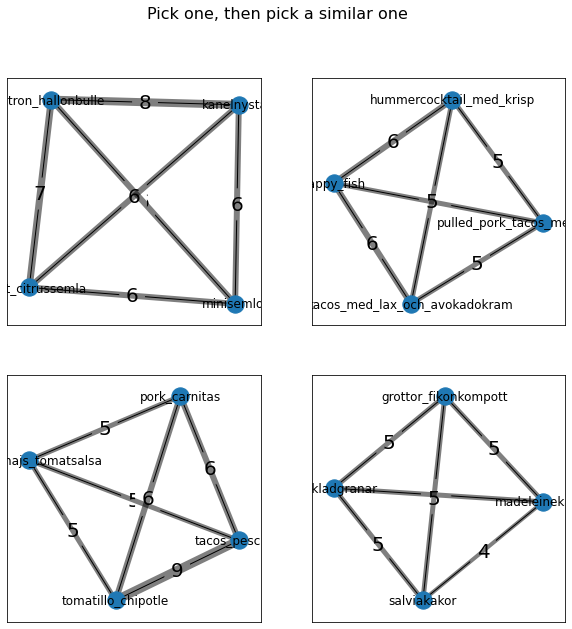

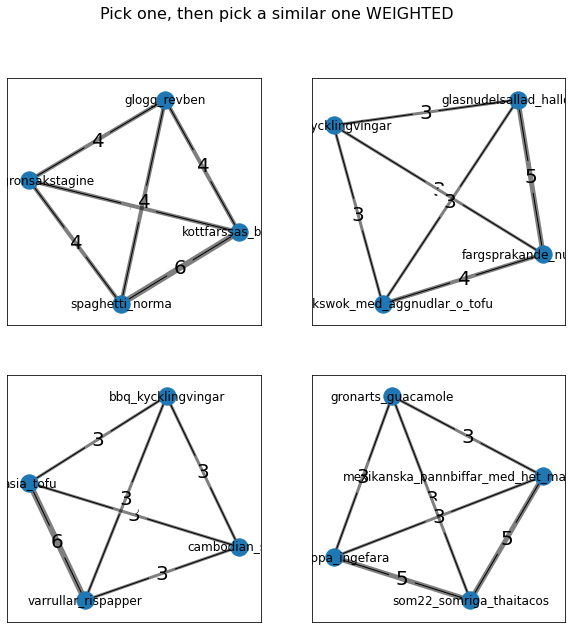

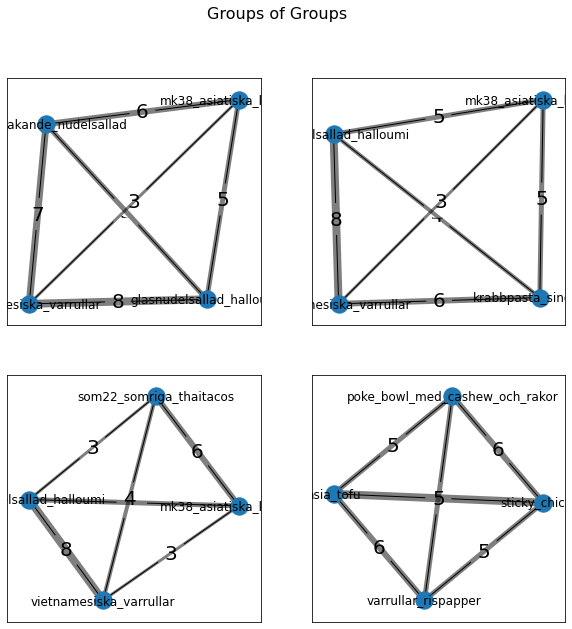

In [17]:
import networkx as nx


def graph_recipes(recipe_names: list[str], ax=None):
    G = nx.Graph()
    G.add_nodes_from(recipe_names)
    for recipe_pair in itertools.combinations(recipe_names, 2):
        share = in_common(recipes2ingredients(recipe_pair))
        if share > 0:
            G.add_edge(*recipe_pair, weight=share)
    pos = nx.spring_layout(G, seed=7)
    labels = nx.get_edge_attributes(G, 'weight')
    weights = list(labels.values())
    if ax:
        nx.draw_networkx(G, pos, ax=ax)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax, font_size=20, rotate=False)
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(),
                               width=weights, alpha=0.5, ax=ax)
    else:
        nx.draw_networkx(G, pos)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_weight=40)
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(),
                               width=weights, alpha=0.5)


fig = plt.figure(1, figsize=(10, 10), facecolor='w')
fig.suptitle("Pick one, then pick a similar one", fontsize=16)
fig, ax = plt.subplots(2, 2, num=1)
for i, P1P_week in enumerate(P1P[:4]):
    graph_recipes(P1P_week[0], ax=ax[i // 2, i % 2])
plt.show()

fig = plt.figure(1, figsize=(10, 10), facecolor='w')
fig.suptitle("Pick one, then pick a similar one WEIGHTED", fontsize=16)
fig, ax = plt.subplots(2, 2, num=1)
for i, P1PW_week in enumerate(P1PW[:4]):
    graph_recipes(P1PW_week[0], ax=ax[i // 2, i % 2])
plt.show()

fig = plt.figure(1, figsize=(10, 10), facecolor='w')
fig.suptitle("Groups of Groups", fontsize=16)
fig, ax = plt.subplots(2, 2, num=1)
for i, GG_week in enumerate(GG[:4]):
    week_recipes = sum(map(list, GG_week[0]), [])
    GG_week = (week_recipes, GG_week[1])
    graph_recipes(GG_week[0], ax=ax[i // 2, i % 2])
plt.show()

## Results
The results show that the winning methods are `pick one, then pick a similar one` and `groups of groups`. The former seems to have greater average shared ingredients. While the later has some large edges inside the subgroups and decently strong inter-group connections. The weighted approach was quite unsuccessful having a comparatively low average shared ingredients.

## Conclusion

This notebook looked solely at different algorithm to find ingredients in common among recipes. There are many other metrics that could be used in order to find recipes that share ingredients. For example, instead of only looking at ingredients shared among all recipes, it might be better to use average number of shared ingredients between a pair of recipes. This might result in the finding of groups of recipes that share more total ingredients. Furthermore, subgroups of highly similar recipes can make the week more interesting. For example, eating only fish and potato based recipes 5 days in a row is probably very boring. While eating sandwiches three days and salad two days in an alternating fashion, is probably more interesting and has a higher number of shared ingredients. This is basically the `groups of groups` approach.

The only problem with the `group of groups` approach is that it is slow as it uses the brute force method to find small groups. This was mostly done for algorithm simplicity, but could easily be changed to a `pick one, then pick a similar one` approach.

Further research will be conducted on methods for finding shared ingredients using other metrics.